In [3]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras.optimizers import Nadam, SGD
import matplotlib.pyplot as plt
tensorflow.compat.v1.disable_eager_execution()

In [2]:
path = f'supercell_kessler_data.npz'
data_link = "https://www.dropbox.com/s/emg7udbs0r250kt/supercell_kessler_data.npz?dl=0"

# Download the data if necessary
if ( not os.path.isfile(path) ):
    print(f"Downloading data from:\n {data_link}...")
    !wget {data_link} -O {path}

# Read pre-shuffled inputs and outputs
npzfile = np.load(path)
input_from_file  = npzfile['input_from_file']
output_from_file = npzfile['output_from_file']

# Total number of sampes in the file
total_samples = input_from_file.shape[0]

# Number of samples I want to use for training in this notebook
num_samples = total_samples

#Get dimension sizes
num_vars_in  = input_from_file .shape[1]
num_vars_out = output_from_file.shape[1]
num_stencil  = input_from_file .shape[2]

# This is a single-cell (non-stencil) Neural Network (NN) modeling approach
# The zeroth stencil index is the cell being predicted
# Load inputs and outputs from file
input  = input_from_file [:num_samples,:,0]
output = output_from_file[:num_samples,:]

# Get dimensions sizes
print('Getting shapes')
print(f'Input shape = {input.shape}')
print(f'Output shape = {output.shape}')
print(f'Total number of data points = {num_samples}')

# Split the dataset into testing and training portions
test_split = 0.2   # 20% of the data will never be trained on (for testing)
num_train_samples = int((1-test_split)*num_samples)
num_test_samples  = num_samples-num_train_samples

print('Scaling the input and output data and saving the scaling parameters')

sclrArrayIn  = np.ndarray(shape=[num_vars_in ,2],dtype=np.single)
sclrArrayOut = np.ndarray(shape=[num_vars_out,2],dtype=np.single)

for ivar in range(num_vars_in) :
  sclrArrayIn [ivar,0] = np.amin(input [:num_train_samples,ivar])
  sclrArrayIn [ivar,1] = np.amax(input [:num_train_samples,ivar])
for ivar in range(num_vars_out) :
  sclrArrayOut[ivar,0] = np.amin(output[:num_train_samples,ivar])
  sclrArrayOut[ivar,1] = np.amax(output[:num_train_samples,ivar])

np.savetxt('supercell_kessler_stencil_input_scaling.txt' , sclrArrayIn , fmt="%s")
np.savetxt('supercell_kessler_stencil_output_scaling.txt', sclrArrayOut, fmt="%s")

for ivar in range(num_vars_in) :
  input [:,ivar] = (input [:,ivar] - sclrArrayIn [ivar,0]) / (sclrArrayIn [ivar,1] - sclrArrayIn [ivar,0])
for ivar in range(num_vars_out) :
  output[:,ivar] = (output[:,ivar] - sclrArrayOut[ivar,0]) / (sclrArrayOut[ivar,1] - sclrArrayOut[ivar,0])

print('Splitting the dataset into training and testing portions')

# Training data
input_train  = input [:num_train_samples, :]
output_train = output[:num_train_samples, :]
# Testing data
input_test   = input [num_train_samples:, :]
output_test  = output[num_train_samples:, :]


Getting shapes
Input shape = (9656443, 5)
Output shape = (9656443, 4)
Total number of data points = 9656443
Scaling the input and output data and saving the scaling parameters
Splitting the dataset into training and testing portions


In [7]:
# Create the Keras Neural Network
model = Sequential()
model.add( Dense(10,input_dim=num_vars_in,kernel_initializer="RandomUniform") )
model.add( LeakyReLU(alpha=0.1) )
model.add( Dense(num_vars_out,kernel_initializer="RandomUniform") )
model.compile(loss='mse', optimizer=Nadam())
print(model.summary())

history = model.fit(input_train, output_train, epochs=3, batch_size=1024, validation_split=0.2, verbose=1)
history = model.fit(input_train, output_train, epochs=3, batch_size=512, validation_split=0.2, verbose=1)
history = model.fit(input_train, output_train, epochs=3, batch_size=256, validation_split=0.2, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                60        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 44        
                                                                 
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6036/6036 [==============================] - 14s 2ms/step - loss: 0.0020 - val_loss: 2.7220e-06
Epoch 2/3
6036/6036 [==============================] - 13s 2ms/step - loss: 7.0569e-07 - val_loss: 8.3502e-07
Epoch 3/3
6036/6036 [==============================] - 11s 2ms/step - loss: 2.7726e-07 - val_loss: 

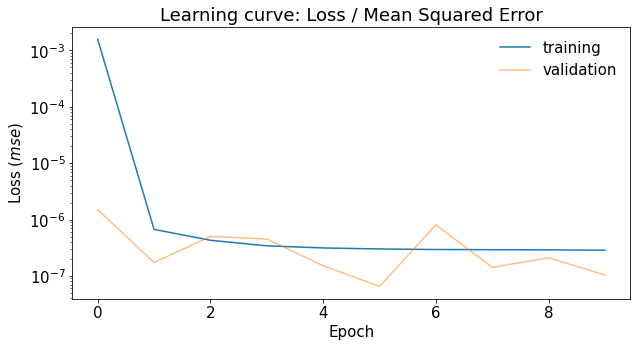

In [53]:
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1,figsize=(10,5),facecolor="1")
axs.set_title('Learning curve: Loss / Mean Squared Error')
axs.plot(history.history['loss'], label='training')
axs.plot(history.history['val_loss'], label='validation', alpha=0.5)
axs.set_xlabel('Epoch'); axs.set_ylabel(f'Loss ($mse$)')
axs.set_yscale('log')
axs.legend(frameon=False);

In [9]:
predict_test = model.predict( input_test )

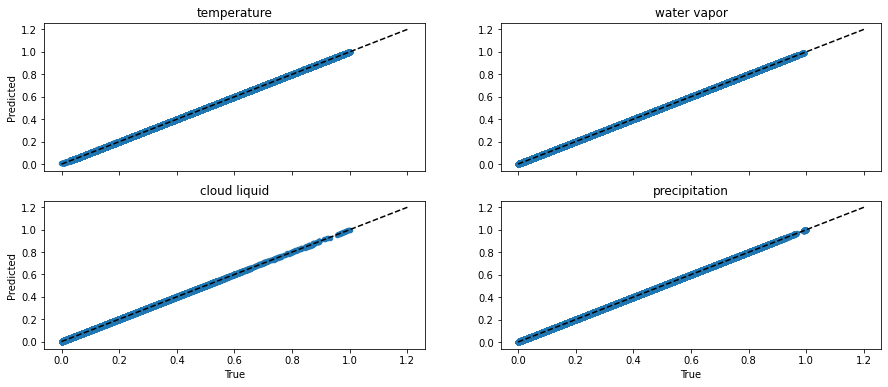

In [10]:
titlestr = np.array(['temperature','water vapor','cloud liquid','precipitation'])

fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(output_test[:,i],predict_test[:,i],s=20)
    axs[i].plot(np.linspace(0,1.2),np.linspace(0,1.2),'--',color='k')
    axs[i].set_title(r''+titlestr[i])
axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
axs[0].set_ylabel(r'Predicted'); axs[2].set_ylabel(r'Predicted');

In [11]:
print( 'Maximum relative test errors: ' , np.amax(np.abs(output_test-predict_test),axis=0) / np.amax(np.abs(output_test),axis=0) )
print( 'Mean relative test errors:    ' , np.mean(np.abs(output_test-predict_test),axis=0) / np.mean(np.abs(output_test),axis=0) )
print( 'Mean relative test bias:      ' , np.mean(output_test-predict_test,axis=0) / np.mean(np.abs(output_test),axis=0) )

Maximum relative test errors:  [0.00696261 0.0028741  0.00604341 0.00331689]
Mean relative test errors:     [0.00016205 0.00125115 0.00410922 0.00333475]
Mean relative test bias:       [ 6.0965398e-05 -1.1189482e-03 -1.7633280e-03  1.9882610e-03]


In [12]:
# For inference: Serialize model to JSON
model_json = model.to_json()
with open('supercell_kessler_singlecell_model_weights.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('supercell_kessler_singlecell_model_weights.h5')
print('Saved model to disk')

Saved model to disk
